In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import json
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
# from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import datetime
import importlib
from simulator import SimulatorMagnetic, SimulatorLennard
from simulator.models import Client, SimulationAlchemy as Simulation
from tqdm.notebook import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging.config
import logging
import sys, os
matplotlib.rcParams["figure.dpi"] = 150
client = Client()

In [2]:
items = client.get_simulation_groups(['Ensemble 5.5.lammps'])
[item.load_df() for item in tqdm(items)];

  0%|          | 0/7992 [00:00<?, ?it/s]

In [3]:
def g(item):
    return abs(item.df["E"].iloc[-1]/item.df["E"].iloc[0] - 1)

In [4]:
for item in items:
    if g(item) > 0.3:
        break
else:
    item = None

In [5]:
def f(item):
    df = item.df
    
    E0 = df.iloc[0]["E"]
    
    start = len(df)//2
    df = df.iloc[start:]
    
    E = df["E"].mean()
    E_end = df["E"].iloc[-1]
    
    
    omega_MLE = df["omega_MLE"].mean()
    
    beta_MLE  = np.mean(df["beta_MLE"].values**(-1))**(-1)
    
    return {"omega_MLE" : omega_MLE,
            "beta_MLE" : beta_MLE,
            "N" : item.particles,
            "L" : df["L"].iloc[0],
            "E" : E0,
            "E_end" : E_end,
            "a" : 0.5*(1/item.a+1/item.b)
           }

In [6]:
df = pd.DataFrame(map(f, tqdm(items)))

  0%|          | 0/7992 [00:00<?, ?it/s]

In [7]:
df["E_nonconserve"] = np.abs(df["E_end"]/df["E"]-1)

In [8]:
len(df[df["E_nonconserve"]>0.005])/len(df)

0.0533033033033033

In [9]:
df = df[df["E_nonconserve"]<0.005]


In [10]:
df.loc[:, "x"] = df.a * df.L / df.E

In [11]:
df["x"] = df.a * df.L / df.E
df["y_beta"] = 3 * df.N/df.E/df.beta_MLE
df["y_omega"] = df.omega_MLE * df.L / df.E

In [12]:
df = df[df["y_beta"] < 1.05]

In [13]:
def f_beta(x):
    return 3 * (1 - x**2)/(2 + np.sqrt(1 + 3 * x**2))
def f_omega(x):
    return np.sqrt(1 + 3 * x**2) - 1

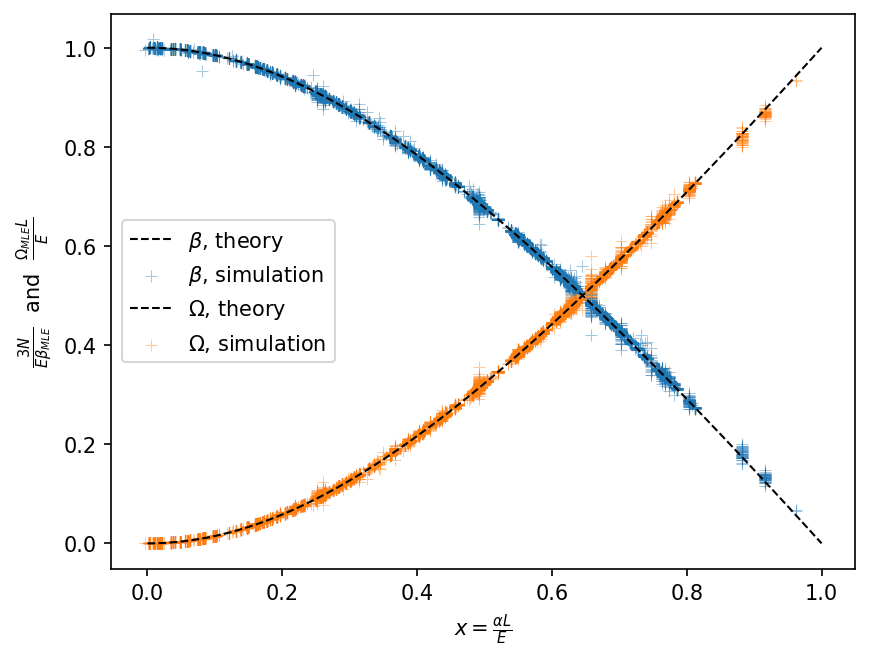

In [14]:
xs = np.linspace(0,1,100)
alpha=0.4
plt.plot(xs, f_beta(xs), "k--", lw=1, label=r"$\beta$, theory")
plt.scatter(df["x"], df["y_beta"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\beta$, simulation")

plt.plot(xs, f_omega(xs), "k--", lw=1, label="$\Omega$, theory")
plt.scatter(df["x"], df["y_omega"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\Omega$, simulation")


plt.xlabel(r"$x=\frac{\alpha L}{E}$")

plt.ylabel(r"$\frac{3 N}{ E \beta_{MLE} }$  and  $\frac{\Omega_{MLE} L}{E}$")
plt.legend()

In [15]:
df[["x","y_beta","y_omega"]].to_csv(
    "beta-omega-plot-data-"+ items[0].group_name.replace(" ", "-") + ".csv", index=False)